In [3]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics



Read CSV

In [18]:
df = pd.read_csv('TrainingData2.csv', encoding='latin-1')
df.head()

,Map_Name,Map_Text
0,Restaurante,SUBWAY MULTIPLAZA ESCA
1,Gasolina,SERVICENTRO EL HIGUERO
2,Restaurante,LA FABRICA PIZZERIA CU
3,Restaurante,ROSTIPOLLOS
4,Supermercado,AUTO MERCADO PL/DEL SO


Add Category Id

In [19]:
df['category_id'] = df['Map_Name'].factorize()[0]
category_id_df = df[['Map_Name', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Map_Name']].values)
df[28:]

,Map_Name,Map_Text,category_id
28,Gasolina,BOMBA LA MARINA,1
29,Restaurante,SUBWAY CIUDAD QUESADA,0
30,Regalos,ALMACENES SIMAN,7
31,Imprevisto,ENTERPRISE CURRIDABAT,8
32,Restaurante,CRCC HOYO 19 N/1,0
...,...,...,...
287,Restaurante,CACIQUITA RESTAUR Y LO HEREDIA,0
288,Restaurante,SUBWAY CIUD,0
289,Restaurante,RESTAURANTE TAIKO ALAJUELA,0
290,Gasolina,ESTAC. DE SERVICIO LOI ALAJUELA,1


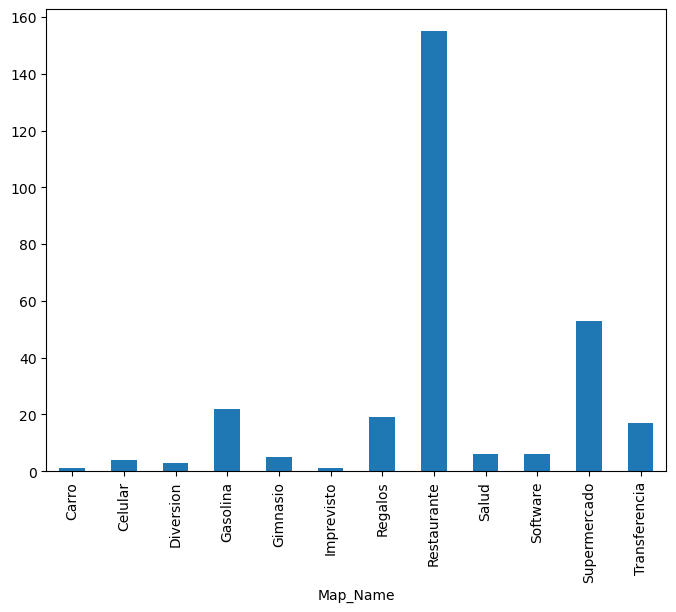

In [20]:
fig = plt.figure(figsize=(8,6))
df.groupby('Map_Name').Map_Text.count().plot.bar(ylim=0)
plt.show()

In [21]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Map_Text).toarray()
labels = df.category_id
features.shape

(292, 65)

In [22]:
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Carro':
  . Most correlated unigrams:
. subway
. del
  . Most correlated bigrams:
. del sol
. subway latina
# 'Celular':
  . Most correlated unigrams:
. subway
. del
  . Most correlated bigrams:
. del sol
. subway latina
# 'Diversion':
  . Most correlated unigrams:
. del
. auto
  . Most correlated bigrams:
. del sol
. subway latina
# 'Gasolina':
  . Most correlated unigrams:
. galera
. servicentro
  . Most correlated bigrams:
. servicentro el
. servicentro la
# 'Gimnasio':
  . Most correlated unigrams:
. subway
. del
  . Most correlated bigrams:
. del sol
. subway latina
# 'Imprevisto':
  . Most correlated unigrams:
. del
. curridabat
  . Most correlated bigrams:
. del sol
. subway latina
# 'Regalos':
  . Most correlated unigrams:
. auto
. carlos
  . Most correlated bigrams:
. subway latina
. san carlos
# 'Restaurante':
  . Most correlated unigrams:
. auto
. subway
  . Most correlated bigrams:
. auto mercado
. subway latina
# 'Salud':
  . Most correlated unigrams:
. san
. plaza
  . 

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df['Map_Text'], df['Map_Name'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = LogisticRegression().fit(X_train_tfidf, y_train)

In [24]:
results = clf.predict(count_vect.transform(["subway"]))
prob_per_class_dictionary = dict(zip(model.classes_, results))

print(prob_per_class_dictionary)


NameError: name 'model' is not defined

/opt/anaconda3/envs/ayan/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/ayan/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/ayan/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/anaconda3/envs/ayan/lib/python3.12/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/var/folders/83/bp8645qn18d5b_7t076brz2w0000gn/T/ipykernel_11060/2050313931.py:17: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to

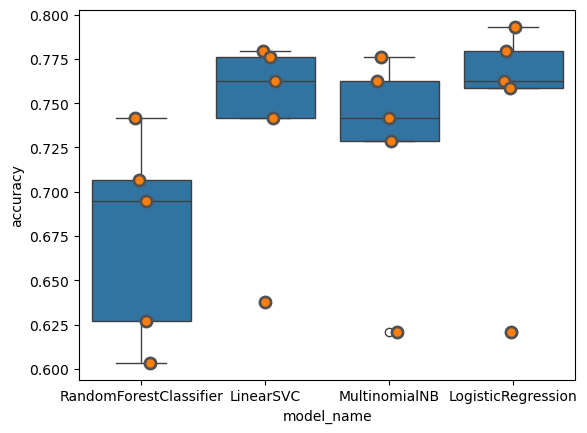

In [25]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [26]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.739509
LogisticRegression        0.742957
MultinomialNB             0.725891
RandomForestClassifier    0.674752
Name: accuracy, dtype: float64

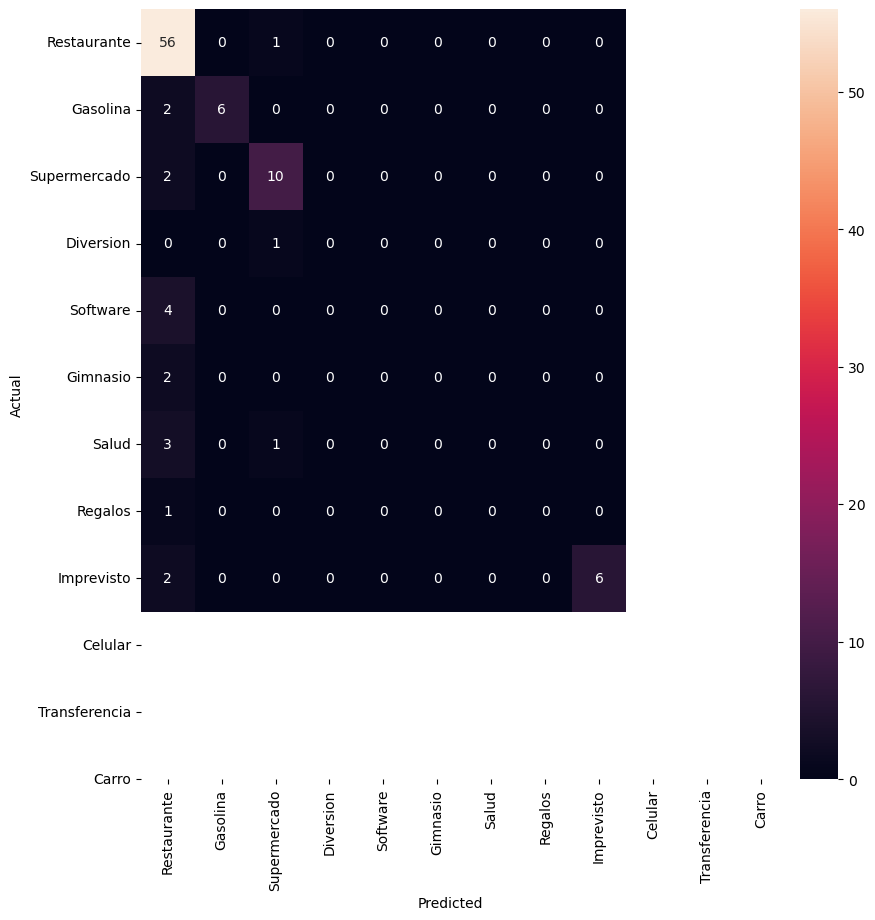

In [27]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Map_Name.values, yticklabels=category_id_df.Map_Name.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [35]:
pd.options.display.float_format = '{:,.2f}'.format
test_data = pd.read_csv('TestData.csv',header=None,encoding='latin-1' ,error_bad_lines=False)
test_data.head()
print()
clf.predict(count_vect.transform(list(test_data[0])))
test_data["predicted"] = clf.predict(count_vect.transform(list(test_data[0])))

test_data.groupby(['predicted']).sum()
test_data.groupby(['predicted']).sum().plot.pie( subplots=True,figsize=(5, 5))


TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'